<a href="https://colab.research.google.com/github/juhhg/RC-Tutorial-2023/blob/main/chapter_2_ESN_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter II: Fine-Tuning the Echo State Network

So far, we have learned to solve the NARMA10 task using the ESN.
In this chapter, we learn techniques to further extract the computational capability from the ESN.

### Goals in Chapter II
- Understand important parameters of ESN
- Understand important perspectives to solve a task

### Parameters of ESN
1. Reservoir size (number of nodes)
1. Input bias
1. Spectral radius
1. Input scale
1. Data size

### Perspectives
1. Rank (degrees of freedom)
1. Degree of memory
1. Length of memory


### Time Schedule
- 13:00-14:00 Chapter II
- 14:00-14:30 Breakout rooms for QA and Homework
 - Room in English
 - Room in Japanese

### Parameter #1: Reservoir Size (Number of Nodes)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Class of ESN (for a single task)
class ESN():
    def __init__(self,N,rho,sigma,p,pin,rseed=0):
        self.N,self.rho,self.sigma,self.p,self.pin = N,rho,sigma,p,pin
        np.random.seed(rseed)
        W = np.random.uniform(-1,1,(N,N))*(np.random.uniform(0,1,(N,N))<p)
        eigs = np.linalg.eigvals(W)
        self.W = rho*W/np.max(np.abs(eigs))
        np.random.seed(rseed+1)
        self.Win = np.random.uniform(-sigma,sigma,N)*(np.random.uniform(0,1,N)<pin)

    def run(self,u,f=np.tanh):
        T = len(u)
        X = np.ones((T,self.N))
        for t in range(1,T):
            X[t] = f(self.W @ X[t-1] + self.Win*u[t-1])
        return X

    def washout(self,X,y,Two):
        T = X.shape[0]-Two
        Xwo = np.hstack([X[Two:],np.ones((T,1))])
        ywo = y[Two:].reshape((T,1))
        return Xwo,ywo

    def linear_regression(self,Xwo,ywo,Ttrain):
        # Split time-series into training and evaluation phases
        Xtrain, Xeval = Xwo[:Ttrain], Xwo[Ttrain:]
        ytrain, yeval = ywo[:Ttrain], ywo[Ttrain:]
        # Calculate wout and output
        wout = np.linalg.pinv(Xtrain) @ ytrain
        yhat = Xeval @ wout
        # NRMSE
        NRMSE = np.sqrt(np.mean((yhat - yeval) ** 2))/np.std(yeval)
        return yeval,yhat,NRMSE

# Function of the NARMA10 model
def narma10(v,a=0.3,b=0.05,c=1.5,d=0.1):
    T = len(v)
    y = np.zeros(T)
    for t in range(10,T):
        y[t] = a * y[t-1] + b * y[t-1] * (np.sum(y[t-10:t])) + c * v[t-10] * v[t-1] + d
    return y



NRMSE [0.29723710772122136, 0.21722875031407965, 0.1855783840256247, 0.1404983990522677, 0.1361166159767696]


Text(0, 0.5, 'NRMSE')

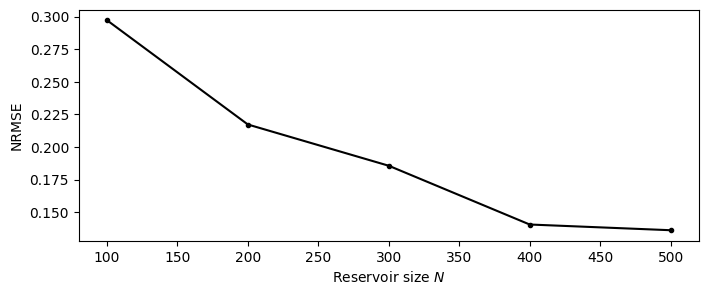

In [ ]:
# Parameters
Two,Ttrain,Teval = 100,2000,1000
T = Ttrain + Teval

Ns = np.arange(100,501,100) # Set of N
rho = 0.9
sigma = 0.1
p,pin = 1,1

# Input
np.random.seed(0)
u_asym = np.random.rand(Two+T) # u_t in [0,1]
u_sym = 2*u_asym-1 # u_t in [-1,1]

# NARMA10
v = 0.5*u_asym # v_t in [0.0,0.5]
y = narma10(v)

# Make empty lists
nrmses = []
for N in Ns:
    esn = ESN(N,rho,sigma,p,pin)
    X = esn.run(u_asym)
    Xwo,ywo = esn.washout(X,y,Two)
    yeval,yhat,nrmse = esn.linear_regression(Xwo,ywo,Ttrain)
    nrmses.append(nrmse)
print('NRMSE',nrmses)

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.plot(Ns,nrmses,color='black',marker='.')
ax.set_xlabel(r'Reservoir size $N$')
ax.set_ylabel('NRMSE')


The number of nodes is a very important factor to improve the computational capability in the ESN because it can directly increase the number of computational resources,
which is evaluated by the rank.

#### Perspective #1: Rank
Some indicators reflect a performance of ESN well.
An important indicator is the rank $r$ (or the effective dimension), which represents the degree of freedom of state and is calculated from the rank of the correlation matrix $\boldsymbol{X}^\top\boldsymbol{X}$.
The rank $r$ means the number of linearly independent state time-series.
For example, the four dimensional state matrix $\boldsymbol{X}=[\boldsymbol{x}_1~\boldsymbol{x}_2~\boldsymbol{x}_3~\boldsymbol{x}_4]\in\mathbb{R}^{T}\times\mathbb{R}^4$ includes the following state time-series vectors
\begin{align}
\boldsymbol{x}_1 &= [1~1\cdots 1]^\top, \\
\boldsymbol{x}_2 &= [u_1 ~ u_2 \cdots u_T]^\top, \\
\boldsymbol{x}_3 &= [u_1^2 ~ u_2^2 \cdots u_T^2]^\top, \\
\boldsymbol{x}_4 &= [3u_1^2-1~3u_2^2-1 \cdots 3u_T^2-1] ^\top.
\end{align}
In this setting, $\boldsymbol{x}_1$, $\boldsymbol{x}_3$, and $\boldsymbol{x}_4$ are linearly dependent because $-\boldsymbol{x}_1+3\boldsymbol{x}_3=\boldsymbol{x}_4$; therefore, the rank of $\boldsymbol{X}$ becomes $r=3$.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

T = 100
np.random.seed(0)
u = 2*np.random.rand(T)-1

x1 = np.ones(T)
x2 = u
x3 = u**2
x4 = 3*(u**2) - 1
X = np.vstack([x1,x2,x3,x4]).T
print('X',X.shape)
r = np.linalg.matrix_rank(X.T @ X)
print('rank',r)

X (100, 4)
rank 3


Let the normalized, linearly independent state be $\boldsymbol{P}\in\mathbb{R}^T\times\mathbb{R}^r$.
For example, the above state matrix $\boldsymbol{X}$ reduces to
$$
\boldsymbol{P} = \left[ \frac{\boldsymbol{x}_1}{||\boldsymbol{x}_1||} ~ \frac{\boldsymbol{x}_2}{||\boldsymbol{x}_2||} ~ \frac{\boldsymbol{x}_3}{||\boldsymbol{x}_3||} \right] \in \mathbb{R}^T\times\mathbb{R}^3,
$$
where we divide $\boldsymbol{x}_i$ by the norm of $\boldsymbol{x}_i$ to normalize the state time-series vector.
Using the matrix $\boldsymbol{P}$, the output of linear regression reduces to
$$
\hat{\boldsymbol{y}} = \boldsymbol{X}(\boldsymbol{X}^\top \boldsymbol{X})^{-1}\boldsymbol{X}^\top \boldsymbol{y} = \boldsymbol{P}\boldsymbol{P}^\top \boldsymbol{y},
$$
which indicates that linear regression utilizes only linearly independent state time-series.
Note that the training and evaluation phases are unified here.
Therefore, in the above example, we waste a computational resource of $\boldsymbol{x}_4$ and use only $\boldsymbol{x}_1, \boldsymbol{x}_2, \boldsymbol{x}_3$.
In summary, the rank is a very important indicator that represents the number of computational resources.


Let's illustrate the relationship between the reservoir size $N$ and the rank $r$.

Reservoir size [ 10  20  30  40  50  60  70  80  90 100]
Rank(tanh) [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
Rank(linear) [10, 20, 24, 31, 34, 42, 42, 44, 49, 45]


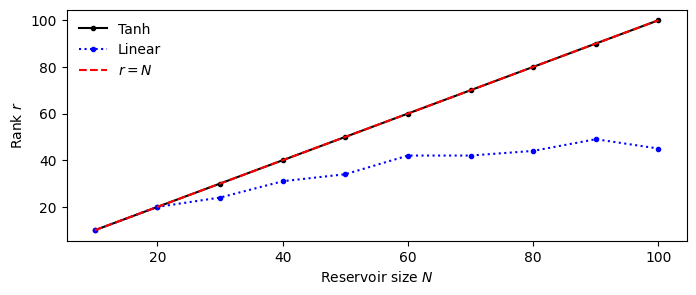

In [ ]:
# Define the identity function y=x
def identity(x):
    return x
# Or you can use a lambda function to describe it more concisely and to calculate it faster
identity = lambda x: x

# Parameters
Two,Ttrain,Teval = 100,2000,1000
T = Ttrain + Teval

rho = 0.9
sigma = 0.1
p,pin = 1,1

# Input
np.random.seed(0)
u_asym = np.random.rand(Two+T)
u_sym = 2*u_asym-1

# Set of N
Ns = np.arange(10,101,10)
print('Reservoir size',Ns)

# Make empty lists
ranks_tanh,ranks_lin = [],[]
for N in Ns:
    esn = ESN(N,rho,sigma,p,pin)
    # Tanh
    X = esn.run(u_asym)
    Xwo = X[Two:]
    rank = np.linalg.matrix_rank(Xwo.T @ Xwo)
    ranks_tanh.append(rank)

    # Linear
    X = esn.run(u_asym,f=identity)
    Xwo = X[Two:]
    rank = np.linalg.matrix_rank(Xwo.T @ Xwo)
    ranks_lin.append(rank)

print('Rank(tanh)',ranks_tanh)
print('Rank(linear)',ranks_lin)

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.plot(Ns,ranks_tanh,color='black',marker='.',label='Tanh')
ax.plot(Ns,ranks_lin,color='blue',marker='.',linestyle=':',label='Linear')
ax.plot(Ns,Ns,color='red',linestyle='--',label=r'$r=N$')
ax.set_xlabel(r'Reservoir size $N$')
ax.set_ylabel(r'Rank $r$')
ax.legend(loc='upper left',frameon=False)

The rank is related to the following factors:
 1. The number of nodes
 1. Type of activation function

 If the number of nodes is large, linear activation function cannot make the enough number of linearly independent state time-series.

 Note that, in the above figure, the linear function is described by
 \begin{align*}
 \boldsymbol{x}_{t+1} &= f(W\boldsymbol{x}_t + \boldsymbol{W}_{\rm in}u_t), \\
 f(y) &= y.
 \end{align*}
 1. Spectral radius
 1. Input scale



### Parameter #2: Input Bias

If we apply an input to the ESN, we biase and scale the input to
\begin{align*}
u_t \leftarrow \mu + \sigma u_t,
\end{align*}
where $\mu$ is the bias and $\sigma$ is the input intensity.
The input bias $\mu$ determines the symmetry of input, which is an important factor to determine ESN's computational capability because the symmetry changes types of input processing in the ESN.

#### Homework in Chapter I
1. Solve the NARMA10 with $v(t)\in[0,0.5]$ using the ESN with $(N,\rho,\sigma,T_{\rm train})=(50,0.9,0.1,2000)$ that receives an asymmetric input $u(t)\in[0,1]$ instead of the symmetric $u(t)\in[-1,1]$.

In [ ]:
# Input
Two,Ttrain,Teval = 100,2000,1000
T = Ttrain + Teval
np.random.seed(0)
u_asym = np.random.uniform(0,1,Two+T) # u in [0,1]
u_sym = 2*u_asym-1 #u in [-1,1]

# ESN parameters
N = 100
rho = 0.9
sigma = 0.1
p,pin = 1,1

# Run NARMA10
v = 0.5*u_asym # v in [0.0,0.5]
y = narma10(v)

# Run ESN
esn = ESN(N,rho,sigma,p,pin)
X = esn.run(u_sym)

Xwo,ywo = esn.washout(X,y,Two)
yeval,yhat,NRMSE = esn.linear_regression(Xwo,ywo,Ttrain)
print('NRMSE (ESN with symmetric input)',NRMSE)

X = esn.run(u_asym)
Xwo,ywo = esn.washout(X,y,Two)
yeval,yhat,NRMSE = esn.linear_regression(Xwo,ywo,Ttrain)
print('NRMSE (ESN with asymmetric input)',NRMSE)

NRMSE (ESN with symmetric input) 0.4097279190915379
NRMSE (ESN with asymmetric input) 0.29723710772122136


2. Using the same setting with practice 1, illustrate the relationship between $N(=100,200,\ldots,1000)$ and NRMSE.

N 100 NRMSE(sym) 0.4097279190915379 NRMSE(asym) 0.29723710772122136
N 200 NRMSE(sym) 0.422516161478584 NRMSE(asym) 0.21722875031407965
N 300 NRMSE(sym) 0.4422112385640458 NRMSE(asym) 0.1855783840256247
N 400 NRMSE(sym) 0.4340568699875367 NRMSE(asym) 0.1404983990522677
N 500 NRMSE(sym) 0.4548908082449015 NRMSE(asym) 0.1361166159767696
N 600 NRMSE(sym) 0.47647559379490945 NRMSE(asym) 0.1297043071707733
N 700 NRMSE(sym) 0.49292075599944846 NRMSE(asym) 0.10651436432144848
N 800 NRMSE(sym) 0.5107026460292015 NRMSE(asym) 0.11236156680229328
N 900 NRMSE(sym) 0.5397351318759707 NRMSE(asym) 0.13305459740045075
N 1000 NRMSE(sym) 0.5647508410246556 NRMSE(asym) 0.13490469001362315


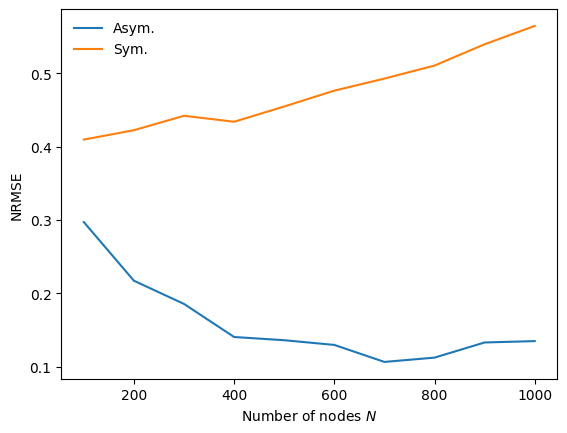

In [ ]:
# Number of nodes
Ns = np.arange(100,1001,100)

nrmses_asym,nrmses_sym = [],[]
for N in Ns:
    # Run ESN
    esn = ESN(N,rho,sigma,p,pin)

    X = esn.run(u_asym)
    Xwo,ywo = esn.washout(X,y,Two)
    yeval,yhat,nrmse_asym = esn.linear_regression(Xwo,ywo,Ttrain)
    nrmses_asym.append(nrmse_asym)

    X = esn.run(u_sym)
    Xwo,ywo = esn.washout(X,y,Two)
    yeval,yhat,nrmse_sym = esn.linear_regression(Xwo,ywo,Ttrain)
    nrmses_sym.append(nrmse_sym)

    print('N',N,'NRMSE(sym)',nrmse_sym,'NRMSE(asym)',nrmse_asym)

plt.figure()
plt.plot(Ns,nrmses_asym,label='Asym.')
plt.plot(Ns,nrmses_sym,label='Sym.')
plt.xlabel(r'Number of nodes $N$')
plt.ylabel('NRMSE')
plt.legend(loc='upper left',frameon=False)

The ESN with asmmetric input outperforms that with symmetric input.
This indicates that the NARMA10 task requires even-order processed inputs.

#### Perspective #2: Degree of Memory
The symmetry of input is a very important factor to solve a task because types of processed inputs held in ESN depend on this factor.

The state equation
\begin{align*}
\boldsymbol{x}_{t+1} &= \tanh(W\boldsymbol{x}_t + \boldsymbol{W}_{\rm in}u_t)
\end{align*}
has an odd activation function [i.e., $\tanh(-y)=-\tanh(y)$]; therefore, if we apply the symmetric input to the ESN, the state holds odd-order processed input (e.g., $u_{t-1}$, $u_{t-1}^3$, and $u_{t-1}^5$), which strongly affects a task performance.
On the other hand, if we apply the asymmetric input, the ESN also holds even-order processed inputs (e.g., $u_{t-1}^2$ and $u_{t-1}^4$).

The NARMA10 task requires the first-order processed inputs ($u_{t-1},u_{t-2},u_{t-3},u_{t-10},u_{t-11},u_{t-12}$) and second-order ones ($u_{t-1}u_{t-10},u_{t-2}u_{t-11},u_{t-3}u_{t-12}$). This decomposition is explained in Chapter V.






4. Solve the NARMA10 with $v(t)\in[-0.5,0.5]$ using the ESN with the symmetric input $u(t)\in[-1,1]$.

In [ ]:
# Number of nodes
N = 50

# Run ESN
esn = ESN(N,rho,sigma,p,pin)
X = esn.run(u_sym)

# NAMRA10 with asymmetiric input
v = 0.5*u_asym
y = narma10(v)
Xwo,ywo = esn.washout(X,y,Two)
yeval,yhat,nrmse_asym = esn.linear_regression(Xwo,ywo,Ttrain)

# NAMRA10 with symmetiric input
v = 0.5*u_sym
y = narma10(v)
Xwo,ywo = esn.washout(X,y,Two)
yeval,yhat,nrmse_sym = esn.linear_regression(Xwo,ywo,Ttrain)

print('N',N,'NRMSE(NARMA10 with symmetric input)',nrmse_sym,'NRMSE(NARMA10 with asymmetric input)',nrmse_asym)


N 50 NRMSE(NARMA10 with symmetric input) 1.010490420406549 NRMSE(NARMA10 with asymmetric input) 0.4049407999246137


This result indicates that the ESN with symmetric input does not hold computational capabilities to solve the NARMA10 with asymmetric input at all.
The processed inputs can be quantified by the memory capacity and information processing capacity (see Chapter IV and V).

### Parameter #3: Spectral Radius
Let the eigenvalues of internal weight matrix $W$ be $\lambda_i~(i=1,\ldots,N)$, and the spectral radius is defined by
$$
\rho = \max_i |\lambda_i|,
$$
which means a maximum expansion rate of state.

For simplicity, we consider a one-dimensional ESN with a linear activation function
$$
x_{t+1} = W x_{t} + W_{\rm in} u_t,
$$
where the weight matrix reduces to $W=\rho$.
If $\rho<1$, the state is stable and converges to a certain range.
On the other hand, if $\rho>1$, $x_t$ diveges to infinity after a long time.

In a case of the activation function of tanh, the state is bounded in the range of $-1<\tanh(\cdot)<1$ and does not diverge to infinity but can exhibit chaos with the large number of nodes.

The spectral radius affects the performance of ESN from three perspectives: rank (degrees of freedom), degree of memory, and memory length.


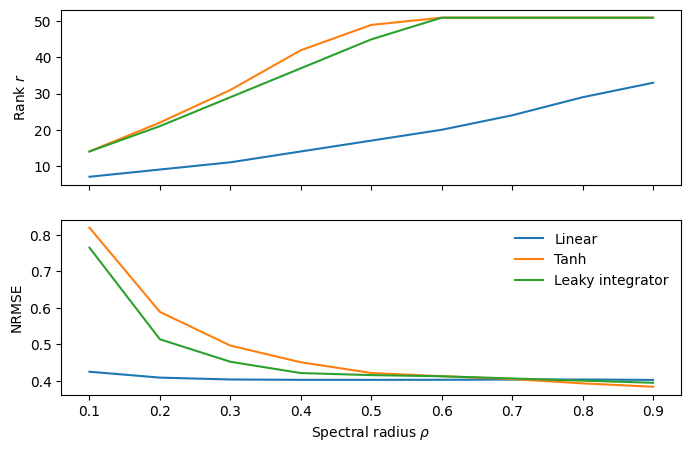

In [ ]:
# Define the identity function y=x
identity = lambda x: x

# Define the activation function of leaky integrator
def run_leaky_integrator(self,u,alpha):
    T = len(u)
    X = np.ones((T,self.N))
    for t in range(1,T):
        X[t] = alpha*X[t-1] + (1-alpha)*np.tanh(self.W @ X[t-1] + self.Win*u[t-1])
    return X
ESN.run_leaky_integrator = run_leaky_integrator

# NARMA10
v = 0.5*u_asym
y = narma10(v)

# Parameters for ESN
rhos = np.arange(0.1,1.0,0.1)
N, sigma, p, pin = 50, 0.1, 1, 1

ranks_lin,ranks_tanh,ranks_int = [],[],[]
nrmses_lin,nrmses_tanh,nrmses_int = [],[],[]
for rho in rhos:
    # Make class instance
    esn = ESN(N,rho,sigma,p,pin)

    # Linear
    X = esn.run(u_asym,f=identity)
    Xwo,ywo = esn.washout(X,y,Two)
    yeval,yhat,NRMSE = esn.linear_regression(Xwo,ywo,Ttrain)
    rank = np.linalg.matrix_rank(Xwo.T @ Xwo)
    ranks_lin.append(rank)
    nrmses_lin.append(NRMSE)

    # Tanh
    X = esn.run(u_asym,f=np.tanh)
    Xwo,ywo = esn.washout(X,y,Two)
    yeval,yhat,NRMSE = esn.linear_regression(Xwo,ywo,Ttrain)
    rank = np.linalg.matrix_rank(Xwo.T @ Xwo)
    ranks_tanh.append(rank)
    nrmses_tanh.append(NRMSE)

    # Leaky integrator
    alpha = 0.1
    X = esn.run_leaky_integrator(u_asym,alpha)
    Xwo,ywo = esn.washout(X,y,Two)
    yeval,yhat,NRMSE = esn.linear_regression(Xwo,ywo,Ttrain)
    rank = np.linalg.matrix_rank(Xwo.T @ Xwo)
    ranks_int.append(rank)
    nrmses_int.append(NRMSE)

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(211)
ax.plot(rhos,ranks_lin,label='Linear')
ax.plot(rhos,ranks_tanh,label='Tanh')
ax.plot(rhos,ranks_int,label='Leaky integrator')
ax.set_xticklabels([])
ax.set_ylabel(r'Rank $r$')

ax = fig.add_subplot(212)
ax.plot(rhos,nrmses_lin,label='Linear')
ax.plot(rhos,nrmses_tanh,label='Tanh')
ax.plot(rhos,nrmses_int,label='Leaky integrator')
ax.set_xlabel(r'Spectral radius $\rho$')
ax.set_ylabel('NRMSE')
ax.legend(loc='upper right',frameon=False)


Here, we additionally use the following activation functions.

Linear function:
$$
\boldsymbol{x}_{t+1} = W\boldsymbol{x}_t + \boldsymbol{W}_{\rm in}u_t.
$$
Leaky integrator:
$$
\boldsymbol{x}_{t+1} = (1-\alpha)\boldsymbol{x}_t + \alpha{\bf \tanh}(W\boldsymbol{x}_t + \boldsymbol{W}_{\rm in}u_t).
$$

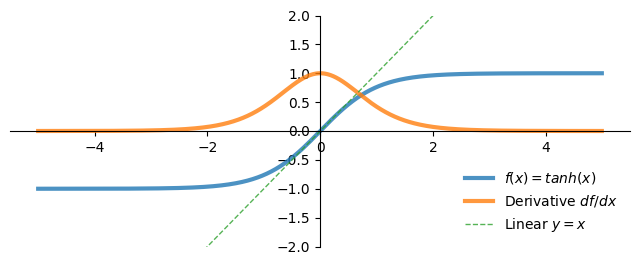

In [ ]:
x = np.arange(-5., 5., 0.01)
f = np.tanh(x)
dfdx = 1 - f**2

fig, ax = plt.subplots(figsize=(8,3))
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.plot(x,f, linewidth=3, label=r"$f(x)=tanh(x)$", alpha=0.8)
ax.plot(x,dfdx, linewidth=3, label=r"Derivative $df/dx$", alpha=0.8)
ax.plot(x,x, linewidth=1, label=r"Linear $y=x$", alpha=0.8,ls='--')
ax.set_ylim(-2,2)
ax.legend(loc="lower right", frameon=False)

According to the shape of activation function, we can extract nonlinearly processed inputs (i.e., their degrees are greater than one) if we use a wide range of state.

#### Perspective #3: Length of Memory
The spectral radius changes not only the rank and degree of memory but also memory length in the ESN.
For simplicity, we use the one-dimensional ESN with linear activation function again. The state equation is described by
$$
x_{t+1} = \rho x_t + w_{\rm in} u_t,
$$
whose solution is analytically obtained as
$$
x_t = w_{\rm in}\sum_{k=1}^\infty \rho^{k-1} u_{t-k}
$$
with the initial value $x_0=0$.
If $\rho$ is small (large), the coefficient $\rho^{k-1}$ of $u_{t-k}$ converges rapidly (slowly) and the state holds short (long) length of input.
This property holds in the ESN with another activation function (e.g., tanh).
Some tasks require long memories (e.g., NARMA10) but others short (e.g., NARMA2 and PAM tasks).
Therefore, the spectral radius should be tuned based on the memory length required in the task.

### Parameter #4: Input Scale

The input scale changes the range of state, which can extract the nonlinearly processed inputs in the same manner as the spectral radius.

Text(0, 0.5, 'NRMSE')

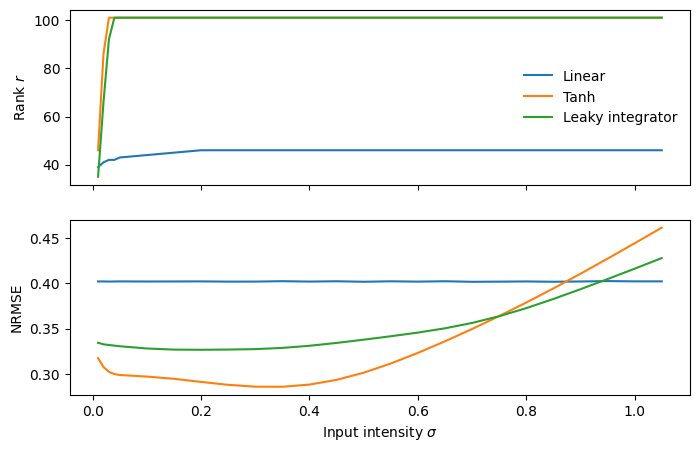

In [ ]:
# NARMA10
v = 0.5*u_asym
y = narma10(v)

# Parameters for ESN
sigmas = np.concatenate([ np.arange(0.01,0.05,0.01),
                          np.arange(0.05,1.1,0.05) ])
N, rho, p, pin = 100, 0.9, 1, 1

ranks_lin,ranks_tanh,ranks_int = [],[],[]
nrmses_lin,nrmses_tanh,nrmses_int = [],[],[]
for sigma in sigmas:
    # Make class instance
    esn = ESN(N,rho,sigma,p,pin)

    # Linear
    X = esn.run(u_asym,f=identity)
    Xwo,ywo = esn.washout(X,y,Two)
    yeval,yhat,NRMSE = esn.linear_regression(Xwo,ywo,Ttrain)
    rank = np.linalg.matrix_rank(Xwo.T @ Xwo)
    ranks_lin.append(rank)
    nrmses_lin.append(NRMSE)

    # Tanh
    X = esn.run(u_asym,f=np.tanh)
    Xwo,ywo = esn.washout(X,y,Two)
    yeval,yhat,NRMSE = esn.linear_regression(Xwo,ywo,Ttrain)
    rank = np.linalg.matrix_rank(Xwo.T @ Xwo)
    ranks_tanh.append(rank)
    nrmses_tanh.append(NRMSE)

    # Leaky integrator
    alpha = 0.1
    X = esn.run_leaky_integrator(u_asym,alpha)
    Xwo,ywo = esn.washout(X,y,Two)
    yeval,yhat,NRMSE = esn.linear_regression(Xwo,ywo,Ttrain)
    rank = np.linalg.matrix_rank(Xwo.T @ Xwo)
    ranks_int.append(rank)
    nrmses_int.append(NRMSE)

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(211)
ax.plot(sigmas,ranks_lin,label='Linear')
ax.plot(sigmas,ranks_tanh,label='Tanh')
ax.plot(sigmas,ranks_int,label='Leaky integrator')
ax.set_xticklabels([])
ax.set_ylabel(r'Rank $r$')
ax.legend(loc='center right',frameon=False)

ax = fig.add_subplot(212)
ax.plot(sigmas,nrmses_lin,label='Linear')
ax.plot(sigmas,nrmses_tanh,label='Tanh')
ax.plot(sigmas,nrmses_int,label='Leaky integrator')
ax.set_xlabel(r'Input intensity $\sigma$')
ax.set_ylabel('NRMSE')


### Parameter #5: Data Size
The accuracy of prediction depends on the length of training and evaluation data.
Here we demonstrate the numerical error caused by the finite length of time-series data.

 46%|████▌     | 460/1000 [00:10<00:05, 93.28it/s]<ipython-input-2-a6d679049e9d>:44: RuntimeWarning: overflow encountered in double_scalars
  y[t] = a * y[t-1] + b * y[t-1] * (np.sum(y[t-10:t])) + c * v[t-10] * v[t-1] + d
<ipython-input-2-a6d679049e9d>:36: RuntimeWarning: overflow encountered in square
  NRMSE = np.sqrt(np.mean((yhat - yeval) ** 2))/np.std(yeval)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
100%|██████████| 1000/1000 [00:16<00:00, 60.38it/s]


Ttrain 100 avg 0.59243145026269 std 0.13664905070461345


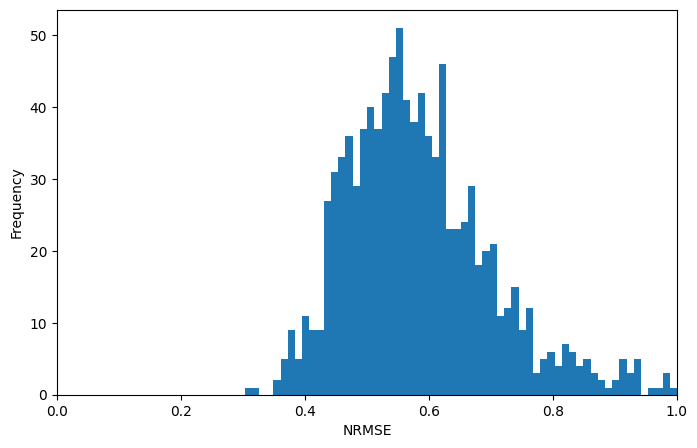

 46%|████▋     | 465/1000 [00:10<00:20, 26.10it/s]<ipython-input-2-a6d679049e9d>:33: RuntimeWarning: invalid value encountered in matmul
  wout = np.linalg.pinv(Xtrain) @ ytrain
100%|██████████| 1000/1000 [00:24<00:00, 40.96it/s]


Ttrain 200 avg 0.4581748842414211 std 0.07143225984875141


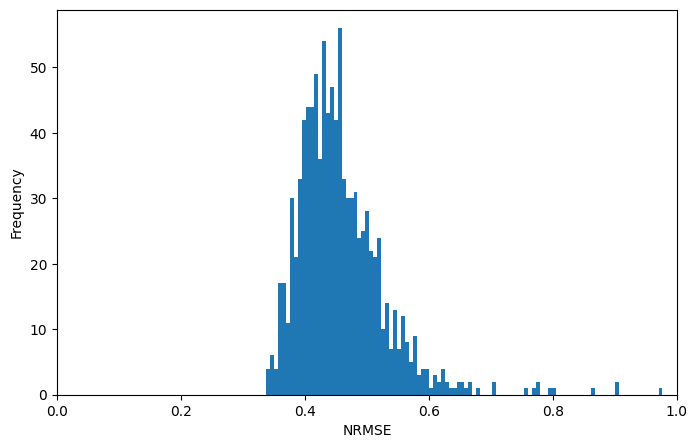

100%|██████████| 1000/1000 [00:24<00:00, 40.30it/s]


Ttrain 300 avg 0.4274082822811417 std 0.05932412525475301


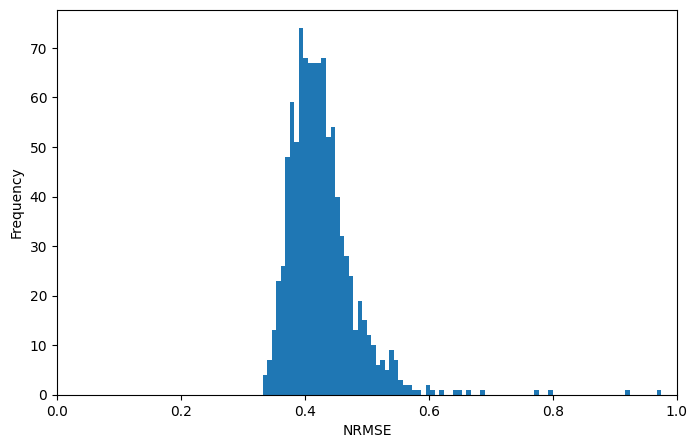

100%|██████████| 1000/1000 [00:37<00:00, 26.88it/s]


Ttrain 500 avg 0.403291771466899 std 0.03927090235248208


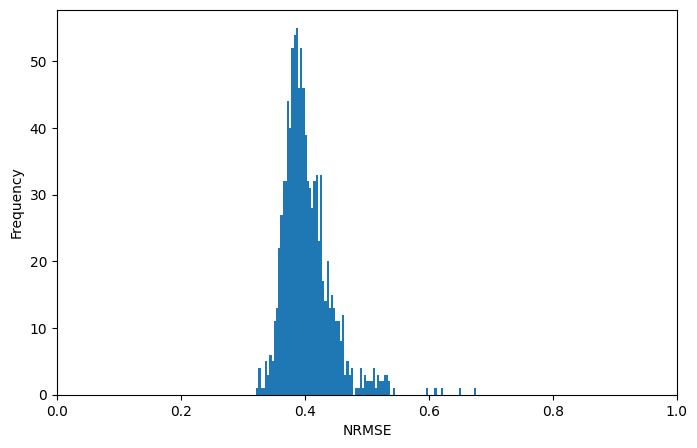

100%|██████████| 1000/1000 [01:06<00:00, 15.10it/s]


Ttrain 1000 avg 0.3849329206872639 std 0.025975204556785165


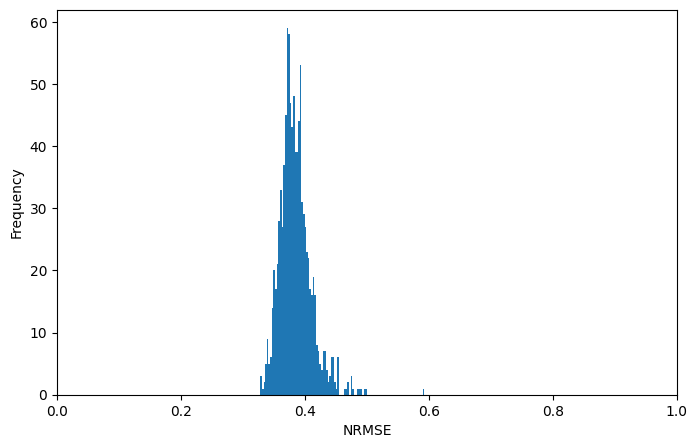

100%|██████████| 1000/1000 [06:52<00:00,  2.43it/s]


Ttrain 10000 avg 0.3705429617463737 std 0.011000439087747942


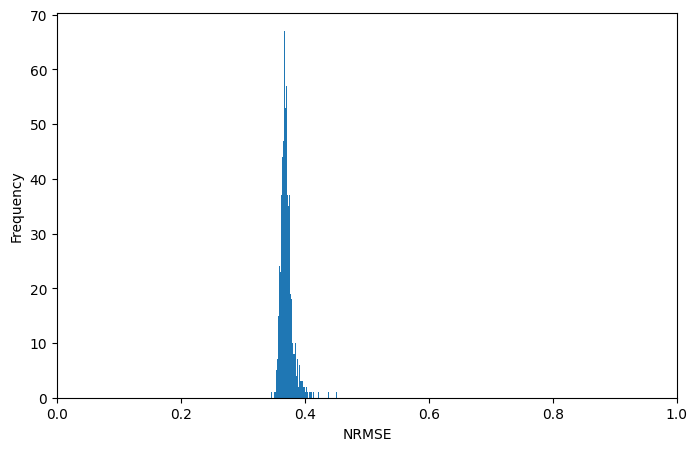

Text(0, 0.5, 'NRMSE')

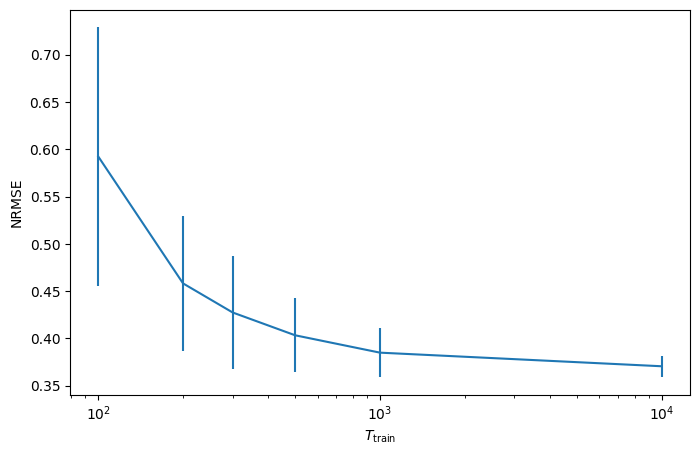

In [ ]:
from tqdm import tqdm

# ESN parameters
Two = 100
N = 50
rho = 0.9
sigma = 0.1
p,pin = 1,1

Ttrains = [100,200,300,500,1000,10000]

avgs,stds = [],[]
for Ttrain in Ttrains:
    Teval = Ttrain
    T = Ttrain + Teval

    nrmses = []
    for seed in tqdm(range(1000)):
        np.random.seed(seed)
        u_asym = np.random.uniform(0,1,Two+T) # u in [0,1]
        u_sym = 2*u_asym-1 # u in [-1,1]

        # Run NARMA10
        v = 0.5*u_asym # v in [0.0,0.5]
        y = narma10(v)
        # y = np.random.permutation(y)

        # Run ESN
        esn = ESN(N,rho,sigma,p,pin)
        X = esn.run(u_asym)
        Xwo,ywo = esn.washout(X,y,Two)
        yeval,yhat,nrmse = esn.linear_regression(Xwo,ywo,Ttrain)
        if ~np.isnan(nrmse):
            nrmses.append(nrmse)
        # print(seed,'NRMSE',nrmse,'NMSE',nmse)
    avg = np.mean(nrmses)
    std = np.std(nrmses)
    print('Ttrain',Ttrain,'avg',avg,'std',std)
    avgs.append(avg)
    stds.append(std)

    plt.figure(figsize=(8,5))
    plt.hist(nrmses,bins=100)#,density=True
    plt.xlim(0,1)
    plt.xlabel('NRMSE')
    plt.ylabel('Frequency')
    plt.show()

plt.figure(figsize=(8,5))
plt.errorbar(Ttrains,avgs,stds)
plt.xscale('log')
plt.xlabel(r'$T_{\rm train}$')
plt.ylabel('NRMSE')

#### Homework in Chapter I
3. Using the same setting with practice 1 but for $T_{\rm train}=10000$, illustrate the relationship between $N(=100,200,\ldots,1000)$ and NRMSE.

 70%|███████   | 7/10 [00:00<00:00,  9.35it/s]<ipython-input-2-a6d679049e9d>:44: RuntimeWarning: overflow encountered in double_scalars
  y[t] = a * y[t-1] + b * y[t-1] * (np.sum(y[t-10:t])) + c * v[t-10] * v[t-1] + d
<ipython-input-2-a6d679049e9d>:36: RuntimeWarning: overflow encountered in square
  NRMSE = np.sqrt(np.mean((yhat - yeval) ** 2))/np.std(yeval)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
 70%|███████   | 7/10 [00:02<00:01,  2.76it/s]<ipython-input-2-a6d679049e9d>:33: RuntimeWarning: invalid value encountered in matmul
  wout = np.linalg.pinv(Xtrain) @ ytrain
100%|██████████| 10/10 [06:19<00:00, 37.94s/it]


Text(0, 0.5, 'NRMSE')

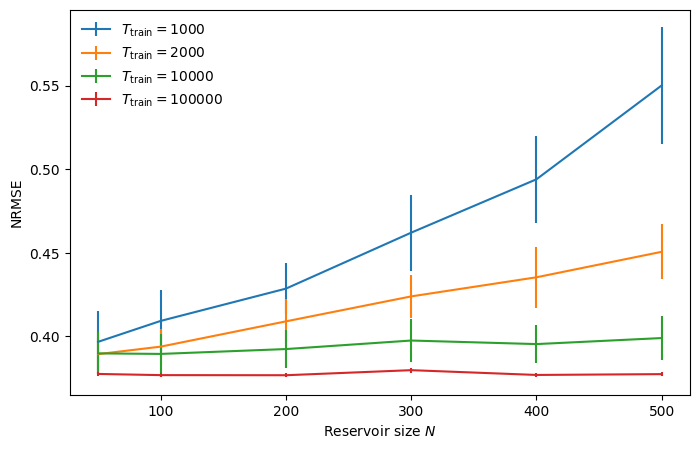

In [ ]:
from tqdm import tqdm

# ESN parameters
Two = 100
rho = 0.9
sigma = 0.1
p,pin = 1,1
Ns = np.array([50,100,200,300,400,500])

plt.figure(figsize=(8,5))
for Ttrain in [1000,2000,10000,100000]:
    Teval = Ttrain
    T = Ttrain + Teval

    avgs,stds = [],[]
    for N in Ns:

        nrmses = []
        for seed in tqdm(range(10)):
            np.random.seed(seed)
            u_asym = np.random.uniform(0,1,Two+T) # u in [0,1]
            u_sym = 2*u_asym-1 # u in [-1,1]

            # Run NARMA10
            v = 0.5*u_asym # v in [0.0,0.5]
            y = narma10(v)
            # y = np.random.permutation(y)

            # Run ESN
            esn = ESN(N,rho,sigma,p,pin)
            X = esn.run(u_sym)
            Xwo,ywo = esn.washout(X,y,Two)
            yeval,yhat,nrmse = esn.linear_regression(Xwo,ywo,Ttrain)
            if ~np.isnan(nrmse):
                nrmses.append(nrmse)
            # print(seed,'NRMSE',nrmse,'NMSE',nmse)
        # print('N',N,'avg',np.mean(nmses),'std',np.std(nmses))
        avgs.append( np.mean(nrmses) )
        stds.append( np.std(nrmses) )

        # plt.figure()
        # plt.hist(nmses,bins=100,density=True)
        # plt.xlabel('NMSE')
        # plt.ylabel('Frequency')
        # plt.show()

    plt.errorbar(Ns,avgs,stds,label=r'$T_{\rm train}=%d$'%Ttrain)
plt.legend(loc='upper left',frameon=False)
plt.xlabel(r'Reservoir size $N$')
plt.ylabel('NRMSE')

According to this result,
- NRMSE decreases as $T_{\rm train}$ increases.
- The biase of NRMSE decreases as $N$ decreases.

Therefore, the data length should be as long as possible.

### Solving a task with short time-series

<strong>Overfitting </strong>

>  <em>"I remember my friend Johnny von Neumann used to say, with four parameters I can fit an elephant, and with five I can make him wiggle his trunk."</em> (Enrico Fermi)

- An output fits the target in the training phase too much and cannot generalize the target in the evaluation phase. This phenomenon is called an overfitting.
- If the training data length $T_{\rm train}$ is not sufficiently larger than  the reservoir size $N$, an overfitting occurs.
- In this case, the learned approximator fails to approximate the data out of training data.
- For ESN, DoF = Number of internal reservoir nodes $N$

<strong>Ridge Regression </strong>

- Add a regularization term in the error function to impose a penalty on the readout weight so that the weights become small
- L2-norm regularization with Ridge parameter $\beta(>0)$
$$
{\rm Err} = \sum_t (  y_{t} - \hat{y}_{t} )^2 + \beta \Vert \boldsymbol{w}^{\rm out} \Vert^2
$$
This regression is called Ridge regression.
The optimized weight and output are given by
\begin{align*}
\hat{\boldsymbol{w}}^{\rm out} &= \arg \min_{\boldsymbol{w}^{\rm out}} {\rm Err} = (\boldsymbol{X}_{\rm train}^\top\boldsymbol{X}_{\rm train} + \beta I )^{-1}\boldsymbol{X}_{\rm train}^\top \boldsymbol{y}_{\rm train}, \tag{1} \\
\hat{y}_t &= [1:\boldsymbol{x}_t]\hat{\boldsymbol{w}}^{\rm out}. \tag{2}
\end{align*}
Note that $(\boldsymbol{X}_{\rm train}^\top\boldsymbol{X}_{\rm train} + \beta I)\in \mathbb{R}^{N+1}\times\mathbb{R}^{N+1}$ with $\beta>0$ is a regular matrix and thus its inverse matrix always exists.

<strong>Akaike Information Criterion </strong>

- We can find the optimal value of $\beta$ using the Akaike information citerion (AIC), which balances the model size and emulation error to make a reasonable model.
The AIC in Ridge regression <sup>[7]</sup> is described by
$$
{\rm AIC} = T_{\rm train} \ln({\rm RSS}) + 2{\rm df}, \tag{3}
$$
where the first term on the R.H.S. reflects the emulation error and the second one represents the model size;
${\rm RSS}$ is the residual sum of squares in the training phase
$$
{\rm RSS}=\sum_{t=1}^{T_{\rm train}} ( y_t - \hat{y}_t)^2;
$$
and the degree of freedom (DoF) is described by
$$
{\rm df} = {\rm tr}[\boldsymbol{X}_{\rm train}(\boldsymbol{X}_{\rm train}^\top\boldsymbol{X}_{\rm train}+\lambda I)^{-1}\boldsymbol{X}_{\rm train}^\top] = \sum_{i=1}^{N+1} \frac{\sigma_i^2}{\sigma_i^2+\beta}, \tag{4}
$$
where $\sigma_i~(i=1,\ldots,N)$ denotes the $i$th singular value of the state matrix $\boldsymbol{X}_{\rm train}$.
Minimizing AIC, we obtain an optimum parameter of $\beta$ and a reasonable model.


- Nakajima Lab's Procedure
 1. The DoF in Eq. (4) is a real number $(0<{\rm df}\le N)$ but we pick up integer DoFs ${\rm df}_j(=1,\ldots,N)$.
Subsequently, we numerically solve Eq. (4) and obtain the corresponding parameters $\beta_{j}$.
In the below script, we use the Newton's method to numerically solve the equation.
\begin{align}
f(\beta) &= {\rm df} - \sum_{i=1}^{N+1} \frac{\sigma_i^2}{\sigma_i^2+\beta}
\end{align}
whose derivative is given by
\begin{align}
\frac{df}{d\beta} &= \sum_{i=1}^{N+1} \frac{\sigma_i^2}{(\sigma_i^2+\beta)^2}.
\end{align}
 2. Using $\beta_j$, we calculate the output in Eq. (2) and AIC in Eq. (3).
 3. Find $\beta_j$ that minimizes the AIC.



NRMSE (Asymmetric input) 0.1361166159767696
df [500 499 498 497 496 495 494 493 492 491 490 489 488 487 486 485 484 483
 482 481 480 479 478 477 476 475 474 473 472 471 470 469 468 467 466 465
 464 463 462 461 460 459 458 457 456 455 454 453 452 451 450 449 448 447
 446 445 444 443 442 441 440 439 438 437 436 435 434 433 432 431 430 429
 428 427 426 425 424 423 422 421 420 419 418 417 416 415 414 413 412 411
 410 409 408 407 406 405 404 403 402 401 400 399 398 397 396 395 394 393
 392 391 390 389 388 387 386 385 384 383 382 381 380 379 378 377 376 375
 374 373 372 371 370 369 368 367 366 365 364 363 362 361 360 359 358 357
 356 355 354 353 352 351 350 349 348 347 346 345 344 343 342 341 340 339
 338 337 336 335 334 333 332 331 330 329 328 327 326 325 324 323 322 321
 320 319 318 317 316 315 314 313 312 311 310 309 308 307 306 305 304 303
 302 301 300 299 298 297 296 295 294 293 292 291 290 289 288 287 286 285
 284 283 282 281 280 279 278 277 276 275 274 273 272 271 270 269 268 267
 266

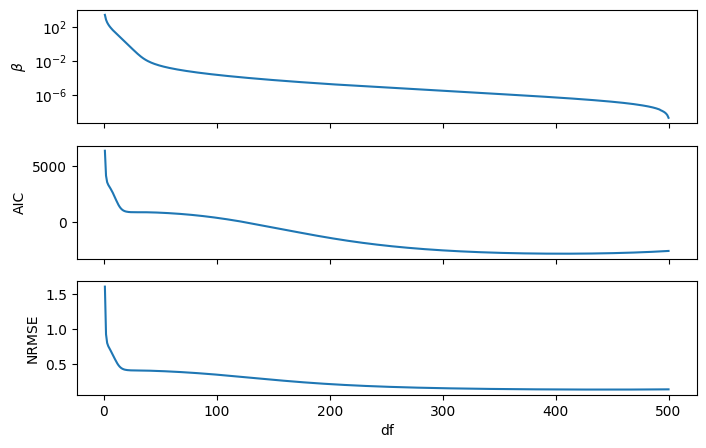

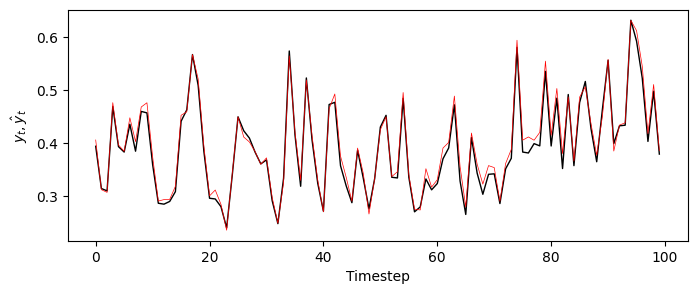

Optimum beta 4.054166961608927e-07 DoF 406 AIC -2784.4930403988806 NRMSE 0.13411535329095273


In [ ]:
from tqdm import tqdm
from scipy.optimize import fsolve,newton

def find_beta(self,Xwo,Ttrain,beta0=1e-13):
    Xtrain = Xwo[:Ttrain]
    sigma = np.linalg.svd(Xtrain)[1]
    lam = np.linalg.eigvals(Xtrain.T @ Xtrain)

    # Derivative of function f
    def fprime(beta):
        return np.sum(lam/(lam+beta)**2)

    betas,dfs = [],[]
    for df in range(self.N+1,0,-1): # [N+1,N,...,0]
        # Function f
        def f(beta):
            return df - np.sum(lam/(lam+beta))
        try:
            beta = newton(f,beta0,fprime)
            betas.append(beta)
            dfs.append(df)
            # print('df',df,'beta',beta)
        except:
            pass

    # Choose only positive values
    dfs,betas = np.array(dfs),np.array(betas)
    dfs = dfs[betas>0]
    betas = betas[betas>0]
    return dfs,betas

def ridge_regression(self,Xwo,ywo,Ttrain,beta):
    # Split time-series into training and evaluation phases
    Xtrain, Xeval = Xwo[:Ttrain], Xwo[Ttrain:]
    ytrain, yeval = ywo[:Ttrain], ywo[Ttrain:]

    # Calculate wout and output
    wout = np.linalg.inv( Xtrain.T @ Xtrain + beta*np.identity(self.N+1)) @ Xtrain.T @ ytrain
    yhat = Xeval @ wout
    # NRMSE
    NRMSE = np.sqrt(np.mean((yhat - yeval) ** 2))/np.std(yeval)
    return yeval,yhat,NRMSE

# Add the two methods to the class of ESN
ESN.find_beta = find_beta
ESN.ridge_regression = ridge_regression

# Input
Two,Ttrain,Teval = 100,2000,1000
T = Ttrain + Teval
np.random.seed(0)
u_asym = np.random.uniform(0,1,Two+T) # u in [0,1]
u_sym = 2*u_asym-1 # u in [-1,1]

# ESN parameters
N = 500
rho = 0.9
sigma = 0.1
p,pin = 1,1

# Run NARMA10
v = 0.5*u_asym # v in [0.0,0.5]
y = narma10(v)

# Run ESN
esn = ESN(N,rho,sigma,p,pin)
X = esn.run(u_asym)
Xwo,ywo = esn.washout(X,y,Two)
yeval,yhat,NRMSE = esn.linear_regression(Xwo,ywo,Ttrain)
print('NRMSE (Asymmetric input)',NRMSE)

dfs,betas = esn.find_beta(Xwo,Ttrain)

aics,nrmses = [],[]
for df,beta in zip(dfs,betas):
    yeval,yhat,nrmse = esn.ridge_regression(Xwo,ywo,Ttrain,beta)
    rss = np.sum((yeval-yhat)**2)
    aic = Ttrain*np.log(rss) + 2*df
    # print(df,nrmse,aic)
    aics.append(aic)
    nrmses.append(nrmse)

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(311)
ax.plot(dfs,betas)
ax.set_xticklabels([])
ax.set_yscale('log')
ax.set_ylabel(r'$\beta$')

ax = fig.add_subplot(312)
ax.plot(dfs,aics)
ax.set_xticklabels([])
ax.set_ylabel('AIC')

ax = fig.add_subplot(313)
ax.plot(dfs,nrmses)
ax.set_xlabel('df')
ax.set_ylabel('NRMSE')
plt.show()

#
beta_opt = betas[np.argmin(aics)]
nrmse_opt = nrmses[np.argmin(aics)]
df_opt = dfs[np.argmin(aics)]
yeval,yhat,NRMSE = esn.ridge_regression(Xwo,ywo,Ttrain,beta_opt)

plt.figure(figsize=(8,3))
plt.plot(yeval[:100],label=r'$y$_t',color='black',linewidth=1)
plt.plot(yhat[:100],label=r'$\hat{y}_t$',color='red',linewidth=0.5)
plt.xlabel('Timestep')
plt.ylabel(r'$y_t, \hat{y}_t$')
plt.legend(loc='lower right',frameon=False)
plt.show()

print('Optimum beta',beta_opt,'DoF',df_opt,'AIC',np.min(aics),'NRMSE',nrmse_opt)


### Grid Search
Finally, we introduce the grid search technique,
which is a simple method to find the best parameter through an exhaustive search.
For example, if we have the three parameters $(\rho,\mu,\sigma)$ of the ESN and each is divided into several values (e.g., $\rho=0.01,0.02,\ldots,1.5$, $\mu=0.01,0.02,\ldots,0.5$, and $\sigma=0.01,0.02,\ldots,0.5$), we find the best parameter set.

In this case, we have to search $150\times50\times50=375000$ combinations, which takes a long time.
If the number of parameters are larger and/or the parameters are divided more finely, a combinational explosion occurs.

To avoid this problem, we use the following procedure:
1. Firstly we divide parameters with a rough width (e.g., $\rho=0.1,0.2,\ldots,1.5$, $\mu=0.1,0.2,\ldots,0.5$, and $\sigma=0.1,0.2,\ldots,0.5$, which reduces the number of combinations to $375$) and search them;
2. Next, using the above results, we narrow down the range of parameters and search the range with finer widths (e.g., we focus on $0.7\le\rho<0.9$ and divide it into $\rho=0.7,0.71,\ldots,0.89$).


In [ ]:
# Step 1.

from tqdm import tqdm

# ESN parameters
Two = 100
Ttrain,Teval = 1000,1000
N = 100
rhos = np.arange(0.1,1.51,0.1)
# rhos = np.arange(0.1,1.51,0.3)
mus = np.arange(0.5,10.01,0.5)
sigmas = np.arange(0.1,0.51,0.1)
p,pin = 1,1

# Input
np.random.seed(0)
u_asym = np.random.uniform(0,1,Two+T) # u in [0,1]
u_sym = 2*u_asym-1 # u in [-1,1]

# Run NARMA10
v = 0.5*u_asym # v in [0.0,0.5]
y = narma10(v)

nrmses = np.zeros((len(rhos),len(mus),len(sigmas)))

for i,rho in enumerate(rhos):
    for j,mu in enumerate(mus):
        for k,sigma in enumerate(sigmas):
            # Biased and scaled input
            u = mu + sigma*u_sym
            # Run ESN
            esn = ESN(N,rho,sigma,p,pin)
            X = esn.run(u)
            Xwo,ywo = esn.washout(X,y,Two)
            yeval,yhat,nrmse = esn.linear_regression(Xwo,ywo,Ttrain)
            print(i,j,k,'rho',rho,'mu',mu,'sigma',sigma,'NRMSE',nrmse)
            nrmses[i,j,k] = nrmse

index = np.unravel_index(np.argmin(nrmses),nrmses.shape)
print(index)
rho_opt,mu_opt,sigma_opt = rhos[index[0]],mus[index[1]],sigmas[index[2]]
print('NRMSE',np.min(nrmses))
print('rho',rho_opt,'mu',mu_opt,'sigma',sigma_opt)


0 0 0 rho 0.1 mu 0.5 sigma 0.1 NRMSE 0.48125420527072155
0 0 1 rho 0.1 mu 0.5 sigma 0.2 NRMSE 0.6230761305744777
0 0 2 rho 0.1 mu 0.5 sigma 0.30000000000000004 NRMSE 0.8504993494693343
0 0 3 rho 0.1 mu 0.5 sigma 0.4 NRMSE 0.8748001454200143
0 0 4 rho 0.1 mu 0.5 sigma 0.5 NRMSE 0.8798204058082967
0 1 0 rho 0.1 mu 1.0 sigma 0.1 NRMSE 0.49160030991608317
0 1 1 rho 0.1 mu 1.0 sigma 0.2 NRMSE 0.6611342455752871
0 1 2 rho 0.1 mu 1.0 sigma 0.30000000000000004 NRMSE 0.8716716321393608
0 1 3 rho 0.1 mu 1.0 sigma 0.4 NRMSE 0.881459531145545
0 1 4 rho 0.1 mu 1.0 sigma 0.5 NRMSE 0.8857433385713267
0 2 0 rho 0.1 mu 1.5 sigma 0.1 NRMSE 0.5009572552785082
0 2 1 rho 0.1 mu 1.5 sigma 0.2 NRMSE 0.6981532960548024
0 2 2 rho 0.1 mu 1.5 sigma 0.30000000000000004 NRMSE 0.876665266810892
0 2 3 rho 0.1 mu 1.5 sigma 0.4 NRMSE 0.8817296264596194
0 2 4 rho 0.1 mu 1.5 sigma 0.5 NRMSE 0.88677291581521
0 3 0 rho 0.1 mu 2.0 sigma 0.1 NRMSE 0.5089149374577838
0 3 1 rho 0.1 mu 2.0 sigma 0.2 NRMSE 0.732376339355113
0 3

Text(0.5, 1.0, '$\\mu=4.5$')

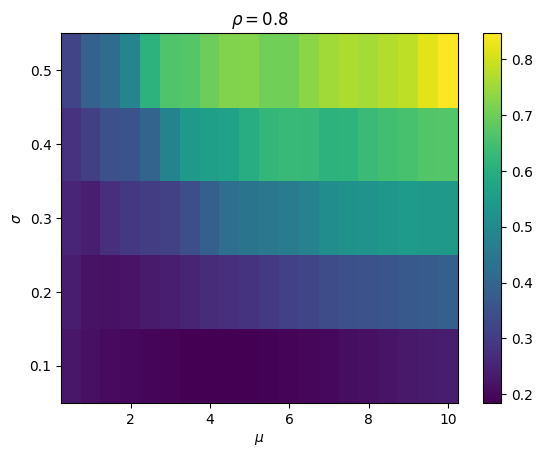

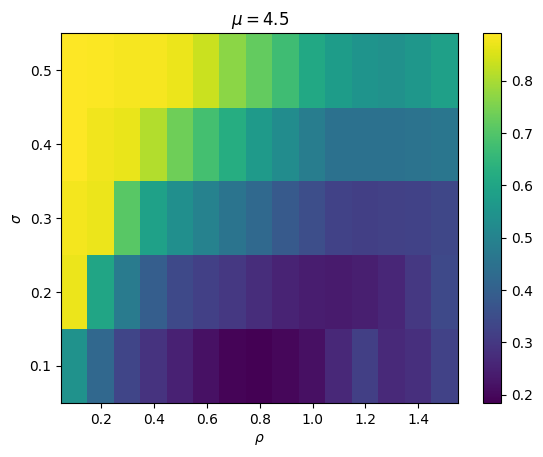

In [ ]:
plt.figure()
plt.pcolor(mus,sigmas,nrmses[index[0]].T)
plt.colorbar()
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
plt.title(r'$\rho=%.1f$'%rho_opt)

plt.figure()
plt.pcolor(rhos,sigmas,nrmses[:,index[1],:].T)
plt.colorbar()
plt.xlabel(r'$\rho$')
plt.ylabel(r'$\sigma$')
plt.title(r'$\mu=%.1f$'%mu_opt)


ストリーミング出力は最後の 5000 行に切り捨てられました。
10 2 3 rho 0.8 mu 4.1 sigma 0.04 NRMSE 0.19556748904597102
10 2 4 rho 0.8 mu 4.1 sigma 0.05 NRMSE 0.19145793229586677
10 2 5 rho 0.8 mu 4.1 sigma 0.060000000000000005 NRMSE 0.18839369513940032
10 2 6 rho 0.8 mu 4.1 sigma 0.06999999999999999 NRMSE 0.18583082835668538
10 2 7 rho 0.8 mu 4.1 sigma 0.08 NRMSE 0.18396294472792468
10 2 8 rho 0.8 mu 4.1 sigma 0.09 NRMSE 0.1836199128242975
10 2 9 rho 0.8 mu 4.1 sigma 0.09999999999999999 NRMSE 0.18493365385174743
10 2 10 rho 0.8 mu 4.1 sigma 0.11 NRMSE 0.18792955834206343
10 2 11 rho 0.8 mu 4.1 sigma 0.12 NRMSE 0.19291604378673488
10 2 12 rho 0.8 mu 4.1 sigma 0.13 NRMSE 0.1997884601187419
10 2 13 rho 0.8 mu 4.1 sigma 0.14 NRMSE 0.20780314268358283
10 2 14 rho 0.8 mu 4.1 sigma 0.15000000000000002 NRMSE 0.2159848159553625
10 2 15 rho 0.8 mu 4.1 sigma 0.16 NRMSE 0.22459730928528004
10 2 16 rho 0.8 mu 4.1 sigma 0.17 NRMSE 0.23485519738863203
10 2 17 rho 0.8 mu 4.1 sigma 0.18000000000000002 NRMSE 0.2468144044033444
10 

Text(0.5, 1.0, '$\\mu=5.0$')

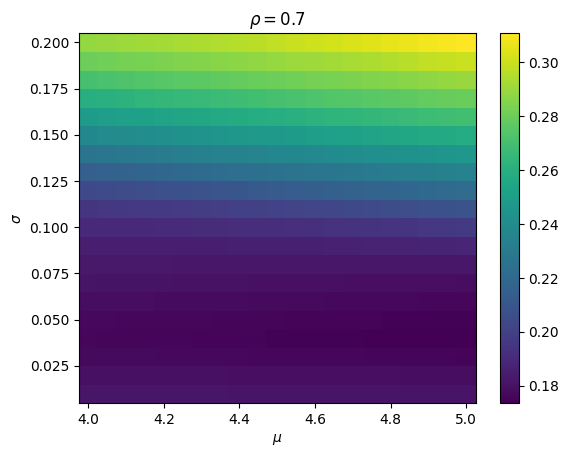

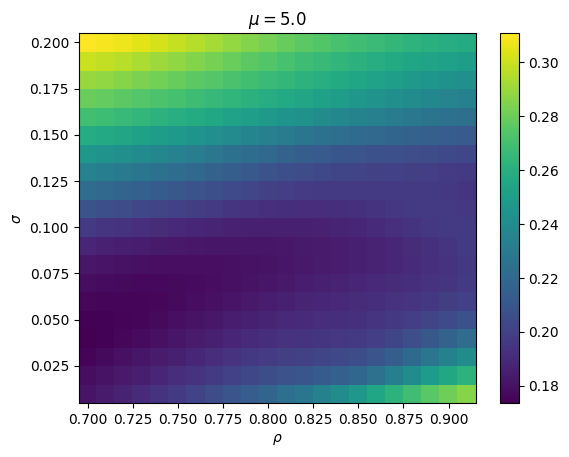

In [ ]:
# Step 2.

# ESN parameters
Two = 100
Ttrain,Teval = 1000,1000
N = 100
rhos = np.arange(0.7,0.91,0.01)
mus = np.arange(4.0,5.01,0.05)
sigmas = np.arange(0.01,0.21,0.01)
p,pin = 1,1

# Input
np.random.seed(0)
u_asym = np.random.uniform(0,1,Two+T) # u in [0,1]
u_sym = 2*u_asym-1 # u in [-1,1]

# Run NARMA10
v = 0.5*u_asym # v in [0.0,0.5]
y = narma10(v)

nrmses = np.zeros((len(rhos),len(mus),len(sigmas)))

for i,rho in enumerate(rhos):
    for j,mu in enumerate(mus):
        for k,sigma in enumerate(sigmas):
            # Biased and scaled input
            u = mu + sigma*u_sym
            # Run ESN
            esn = ESN(N,rho,sigma,p,pin)
            X = esn.run(u)
            Xwo,ywo = esn.washout(X,y,Two)
            yeval,yhat,nrmse = esn.linear_regression(Xwo,ywo,Ttrain)
            print(i,j,k,'rho',rho,'mu',mu,'sigma',sigma,'NRMSE',nrmse)
            nrmses[i,j,k] = nrmse

index = np.unravel_index(np.argmin(nrmses),nrmses.shape)
print(index)
rho_opt,mu_opt,sigma_opt = rhos[index[0]],mus[index[1]],sigmas[index[2]]
print('NRMSE',np.min(nrmses))
print('rho',rho_opt,'mu',mu_opt,'sigma',sigma_opt)

plt.figure()
plt.pcolor(mus,sigmas,nrmses[index[0]].T)
plt.colorbar()
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
plt.title(r'$\rho=%.1f$'%rho_opt)

plt.figure()
plt.pcolor(rhos,sigmas,nrmses[:,index[1],:].T)
plt.colorbar()
plt.xlabel(r'$\rho$')
plt.ylabel(r'$\sigma$')
plt.title(r'$\mu=%.1f$'%mu_opt)


In summary,
- The reservoir size $N$ increases the rank
- The spectral radius $\rho$ adjusts the rank, degree of memory, and length of memory
- The input bias $\mu$ and intensity $\sigma$ adjust the degree of memory
- The data size biases the NRMSE
- If we use short time-series, we can use the Ridge regression
- We can find the best parameters using the grid search method

### Homework—Contest

Let's solve the following PAM task using an ESN whose reservoir size is $N\le500$.
You can use any
- type of activation function
- spectral radius
- input bias and intensity


#### Pneumatic artifical muscle (PAM) length emulation task<sup>[5, 6]</sup>

- The edge computing task in robotics (real-world task)
- Predicting length of PAM from random input pressure value
- The dynamics of PAM has hysteresis and nonlinearity (friction)
- Require memory and nonlinearity to solve

The McKibben PAM is frequently used as a practical soft robot device because of its advantages of being ultralightweight and powerful. The dynamics of PAM are very complex for high dimensionality and nonlinearity; hence the length of PAM is usually measured by an infrared sensor. However, there is a problem because the infrared sensor, as a rigid device, loses the softness of the PAM.

The physics model-based method is also not practical because it requires estimating many parameters. However, an ESN can solve this task with the same accuracy as an infrared sensor<sup>[4]</sup>. Since this task aims to replace the sensor, it can be said to be an edge-computing task suitable for RC. The input signal of this task is a pressure value that is injected in the PAM, and the target signal is the length of the PAM at the time of switching to the next input signal.

In this task, the data is obtained from an experiment involving an actual PAM device. See Ref. [5] for further details of the experiment. The training and evaluation data sets used in this experiment are provided in Ref. [6].

<center>
    <img src="https://drive.google.com/uc?export=view&id=1mXzEzXebba2V5OHT-J977TURW4mcSzL3" style="width:750px;height:300px;">
<figcaption align = "center"><b>Fig.4 Pneumatic artifical muscle (PAM) length emulation from random input pressure value<sup>[5,6]</sup></b></figcaption>
</center>


#### Contest
After solving the following PAM task using the ESN, you can send us (rc-tutorial-TA@googlegroups.com) the score of NRMSE and your evaluation data $\{\hat{y}_t\}$ and ESN's parameters if you like to join a contest.
Please find the best score by the above techniques.

Due date: June 2nd (Fri)

In [ ]:
# You can use a Unix command by placing '!' before the command
!ls -l

# Mount your Google drive
import sys
from google.colab import drive  # Connecting to google drive

if 'google.colab' in sys.modules:
    drive.mount('/content/gdrive')
    !ls -l /content/gdrive/MyDrive/RC_tutorial_2023/notebooks/data
    # %cd /content/gdrive/MyDrive/RC_tutorial_2023/notebooks/data

total 8
drwx------ 6 root root 4096 May  2 06:49 gdrive
drwxr-xr-x 1 root root 4096 Apr 28 13:35 sample_data
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
total 1654
-rw------- 1 root root  380022 Apr  9 10:31 NARMA10_length_5000.txt
-rw------- 1 root root 1312709 Apr  9 10:31 PAM_length_emulation.txt


(49998, 3)


Text(0, 0.5, 'Target $y_t$')

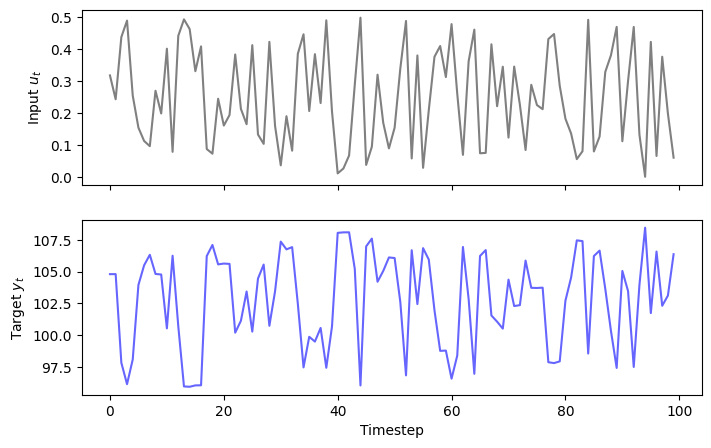

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
"""
Data is provided as the following format
The second column is the input
The last column is the target

#index pressure[MPa] length[mm]
1 0.316983 104.795449
2 0.242617 104.798671
3 0.436618 97.827733
4 0.488036 96.144599
5 0.254115 98.085438
6 0.153881 103.94824
7 0.112385 105.494478
8 0.096129 106.317529
9 0.269139 104.813167
10 0.198266 104.768068
"""

# Data directory
datadir = '/content/gdrive/MyDrive/RC_tutorial_2023/notebooks/data'

with open(datadir + '/PAM_length_emulation.txt') as rf:
    lines = (line for line in rf if not line.startswith('#'))
    arr = np.loadtxt(lines, delimiter=' ', skiprows=0)
    print(arr.shape)

Two = 998
Ttrain = 40000
Teval  = 9000
u,y = arr[:,1],arr[:,2]

# Plot the data
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(211)
ax.plot(u[:100],c='grey')
ax.set_xticklabels([])
ax.set_ylabel(r'Input $u_t$')

ax = fig.add_subplot(212)
ax.plot(y[:100],c='blue',alpha=0.6)
ax.set_xlabel('Timestep')
ax.set_ylabel(r'Target $y_t$')


## References

[1] H. Jaeger, <em>The “echo state” approach to analysing and training recurrent neural networks-with an erratum note</em>, Bonn Germany: German National Research Center for Information Technology GMD Technical Report, 148(34), 13 (2001)

[2] H. Jaeger, <em>Tutorial on training recurrent neural networks, covering BPPT, RTRL, EKF and the "echo state network" approach</em>, Bonn: GMD-Forschungszentrum Informationstechnik (2002)

[3] K. Nakajima, <em>Physical reservoir computing---an introductory perspective</em>, Japanese Journal of Applied Physics 59: 060501 (2020)

[4] A. F. Atiya, A. G. Parlos, <em>New results on recurrent network training: unifying the algorithms and accelerating convergence</em>, IEEE Transactions on Neural Networks, 11.3, 697-709 (2000)

[5] R. Sakurai, M. Nishida, H. Sakurai, Y. Wakao, N. Akashi, Y. Kuniyoshi, Y. Minami, and K. Nakajima, <em>Emulating a sensor using soft material dynamics: A reservoir computing approach to pneumatic artificial muscle</em>, 3rd IEEE International Conference on Soft Robotics (RoboSoft), IEEE (2020)

[6] N. Akashi, T. Yamaguchi, S. Tsunegi, T. Taniguchi, M. Nishida, R. Sakurai, Y. Wakao, and K. Nakajima, <em>Input-Driven Bifurcations and Information Processing Capacity in Spintronics Reservoirs</em>, Physical Review Research 2, 043303 (2020)
  
[7] K. Goto, K. Nakajima, and H. Notsu, <em>Twin vortex computer in fluid flow</em>, New Journal of Physics, 23(6), 063051 (2021)